# Spam SMS Detection using Machine Learning

## Objective
The goal of this project is to build a machine learning model that classifies SMS messages as either **spam** or **legitimate (ham)**. This is a binary text classification task using classifiers like **Logistic Regression** and **Support Vector Machines (SVM)**.


## Import Required Libraries
We begin by importing libraries for data manipulation, preprocessing, model training, and evaluation.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import resample
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk

In [4]:
!pip install wordcloud



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install nltk



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load the SMS Spam Dataset
We load the dataset, which contains two columns:
- `v1`: Label (`spam` or `ham`)
- `v2`: The SMS message text

In [6]:
sms = pd.read_csv(r'C:\Users\Rhythm\OneDrive\Desktop\Manya\Spam detection\spam.csv', encoding='latin-1')

## Data Preprocessing
- Rename columns for clarity.
- Encode labels (`spam` = 1, `ham` = 0).
- Clean and normalize the text (e.g., lowercasing, punctuation removal).


In [7]:
sms = sms.loc[:, ~sms.columns.str.contains('^Unnamed')]

In [8]:
sms = sms.rename(columns={'v1': 'label', 'v2': 'message'})

In [9]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
sms.shape

(5572, 2)

In [11]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [12]:
sms.isnull().sum()

label      0
message    0
dtype: int64

In [13]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [14]:
sms["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [15]:
sns.set_style("whitegrid")

In [16]:
sms_df = sms.copy()

In [17]:
label_counts = sms_df['label'].value_counts()

## Data Visualisatiion

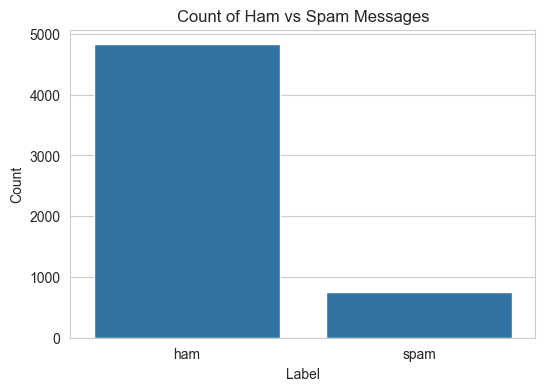

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(data=sms_df, x='label')
plt.title('Count of Ham vs Spam Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

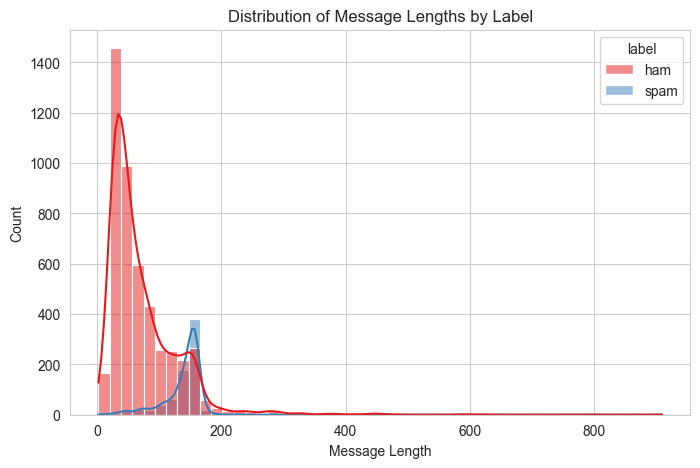

In [19]:
sms_df['message_length'] = sms_df['message'].apply(len)

# Distribution of message lengths
plt.figure(figsize=(8,5))
sns.histplot(data=sms_df, x='message_length', hue='label', bins=50, kde=True, palette='Set1')
plt.title('Distribution of Message Lengths by Label')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()


In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rhythm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def get_top_n_words(messages, n=15):
    words = ' '.join(messages).lower().translate(str.maketrans('', '', string.punctuation)).split()
    words = [word for word in words if word not in stop_words]
    return Counter(words).most_common(n)

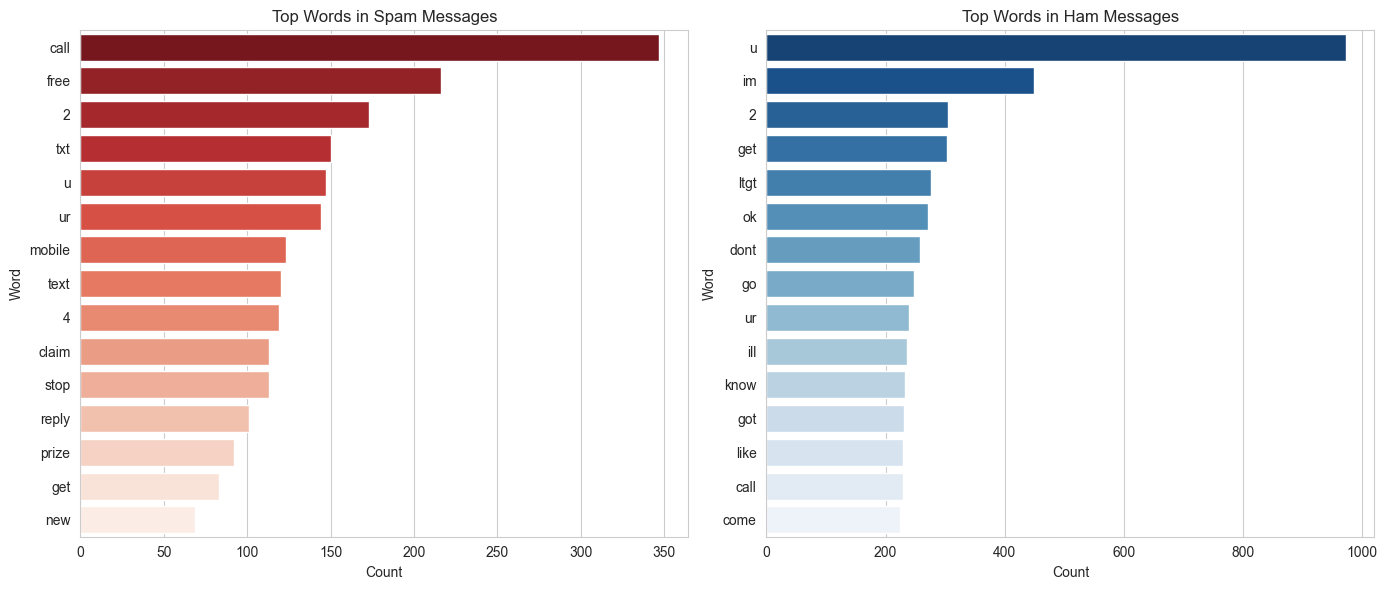

In [22]:
spam_top = get_top_n_words(sms_df[sms_df['label'] == 'spam']['message'])
ham_top = get_top_n_words(sms_df[sms_df['label'] == 'ham']['message'])

# Convert to DataFrames
spam_df = pd.DataFrame(spam_top, columns=['word', 'count'])
ham_df = pd.DataFrame(ham_top, columns=['word', 'count'])

# Convert 'count' to integers
spam_df['count'] = spam_df['count'].astype(int)
ham_df['count'] = ham_df['count'].astype(int)

# Plot side-by-side
plt.figure(figsize=(14,6))

# Spam plot
plt.subplot(1, 2, 1)
sns.barplot(data=spam_df, x='count', y='word', palette='Reds_r')
plt.title('Top Words in Spam Messages')
plt.xlabel('Count')
plt.ylabel('Word')

# Ham plot
plt.subplot(1, 2, 2)
sns.barplot(data=ham_df, x='count', y='word', palette='Blues_r')
plt.title('Top Words in Ham Messages')
plt.xlabel('Count')
plt.ylabel('Word')

plt.tight_layout()
plt.show()

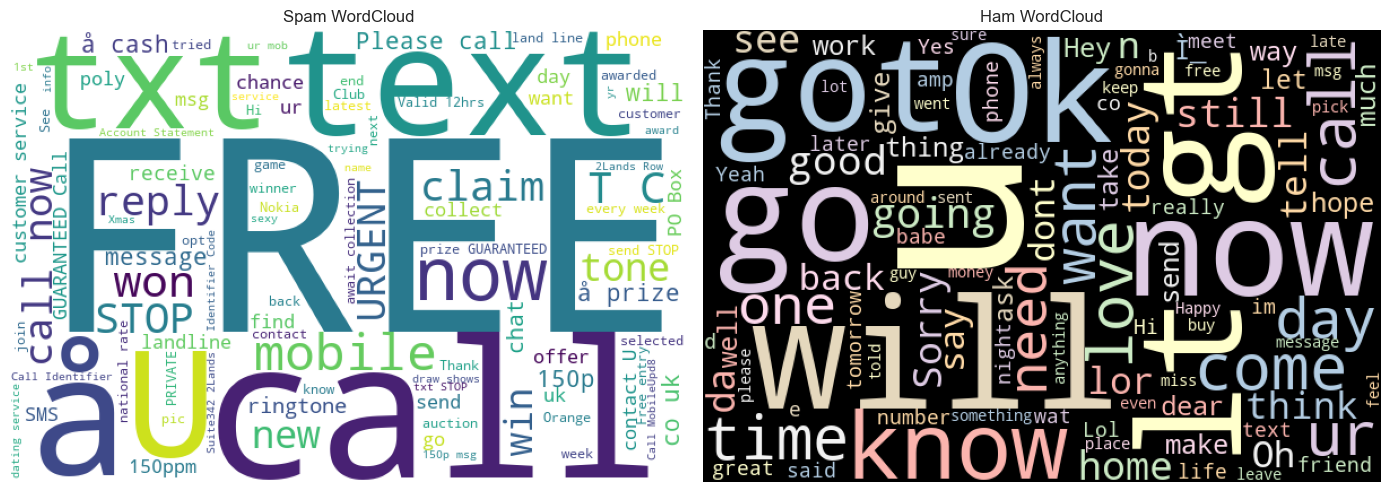

In [23]:
# Word Clouds
spam_words = ' '.join(sms_df[sms_df['label']=='spam']['message'])
ham_words = ' '.join(sms_df[sms_df['label']=='ham']['message'])
custom_stopwords = set(STOPWORDS)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color='white',
                     stopwords=custom_stopwords, max_words=100).generate(spam_words))
plt.title('Spam WordCloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='black',
                     stopwords=custom_stopwords, colormap='Pastel1', max_words=100).generate(ham_words))
plt.title('Ham WordCloud')
plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
sms_df['label_num'] = sms_df['label'].map({'ham': 0, 'spam': 1})

In [25]:
def clean_text(text):
   text = text.lower()
   text = ''.join([char for char in text if char not in string.punctuation])
   words = text.split()
   words = [word for word in words if word not in stopwords.words('english')]
   return ' '.join(words)

sms_df['cleaned_message'] = sms_df['message'].apply(clean_text)

## Convert Text to Numerical Features using TF-IDF
We convert the SMS messages into numerical vectors using the TF-IDF technique, which captures the importance of words across messages.


In [26]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = tfidf.fit_transform(sms_df['cleaned_message']).toarray()
y = sms_df['label_num']
tfidf

TfidfVectorizer(max_features=3000, ngram_range=(1, 2))

In [27]:
# Message Length
X = np.hstack((X, sms_df['message_length'].values.reshape(-1, 1)))  # Combine with TF-IDF
X

array([[  0.,   0.,   0., ...,   0.,   0., 111.],
       [  0.,   0.,   0., ...,   0.,   0.,  29.],
       [  0.,   0.,   0., ...,   0.,   0., 155.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,  57.],
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0.,  26.]])

## Split the Data
We split the dataset into training and testing sets to evaluate model performance on unseen data.


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Support Vector Machine (SVM) Model
We train a Support Vector Machine classifier with a linear kernel and evaluate it.


In [29]:
svm_clf = SVC(random_state=42, class_weight='balanced')
svm_clf.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [30]:
y_pred = svm_clf.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.98      0.81      0.88       966
        Spam       0.41      0.87      0.56       149

    accuracy                           0.82      1115
   macro avg       0.69      0.84      0.72      1115
weighted avg       0.90      0.82      0.84      1115



In [32]:
cm = confusion_matrix(y_test, y_pred)

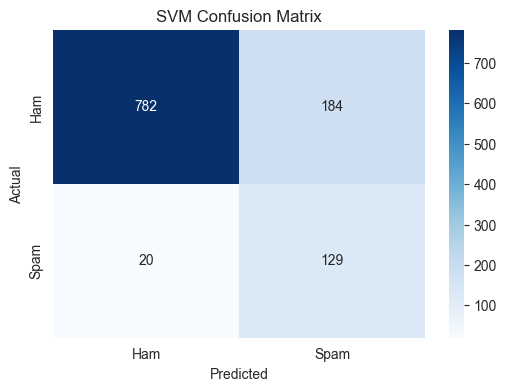

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 81.70%


## Logistic Regression Model
We train a Logistic Regression model and evaluate its performance using accuracy, precision, recall, F1 score, and confusion matrix.


In [35]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [36]:
scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='f1')
print("Cross-validated F1 scores:", scores.mean(), "+/-", scores.std())

Cross-validated F1 scores: 0.8676670949342687 +/- 0.011321803290250084


In [37]:
y_train_pred_lr = cross_val_predict(log_reg, X_train, y_train, cv=3)
print("LR Train F1-Score:", f1_score(y_train, y_train_pred_lr))

LR Train F1-Score: 0.8677165354330708


In [38]:
y_pred_lr = log_reg.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_lr, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       966
        Spam       0.85      0.93      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.95      0.93      1115
weighted avg       0.97      0.97      0.97      1115



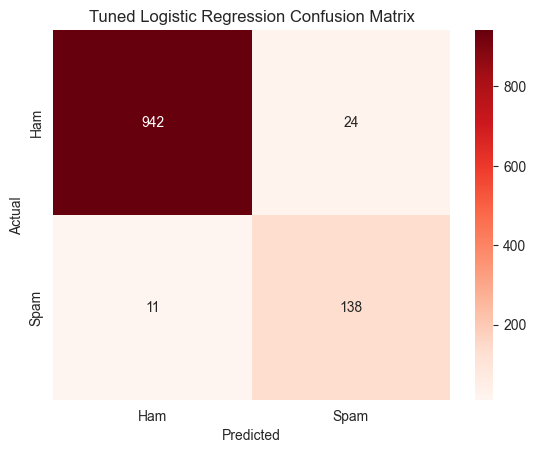

In [40]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.86%


In [42]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='f1')
grid_search_lr.fit(X_train, y_train)
log_reg = grid_search_lr.best_estimator_
y_pred_lr = log_reg.predict(X_test)
print("Best LR params:", grid_search_lr.best_params_)
print("LR Test F1-Score:", f1_score(y_test, y_pred_lr))

Best LR params: {'C': 100}
LR Test F1-Score: 0.9550173010380623


In [43]:
scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='f1')
print("Cross-validated F1 scores:", scores.mean(), "+/-", scores.std())
y_train_pred_lr = cross_val_predict(log_reg, X_train, y_train, cv=3)
print("LR Train F1-Score:", f1_score(y_train, y_train_pred_lr))

Cross-validated F1 scores: 0.9267957562705625 +/- 0.005430299679501927
LR Train F1-Score: 0.9267461669505963


In [44]:
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))

Precision: 0.9857142857142858
Recall: 0.9261744966442953


## Testing on Real World Data

In [57]:
# TF-IDF and training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sms['message'])
y = sms['label'].map({'ham': 0, 'spam': 1})

model = LogisticRegression(class_weight='balanced')
model.fit(X, y)

# Prediction function
def predict_sms(text):
    text_tfidf = tfidf.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return "Spam" if prediction == 1 else "Ham"

# Try messages
print(predict_sms("Congratulations! You've won a free iPhone! Click here to claim now."))
print(predict_sms("Hey! Just checking if you're free this evening."))


Spam
Ham


In [56]:
print(predict_sms("Congratulations! You've won a free vacation to the Bahamas. Call now!"))
print(predict_sms("Hey, are we still on for the meeting at 3 PM today?"))


Spam
Ham


In [58]:
sample_messages = [
    "Get free recharge by clicking this link now!",
    "Are you coming to the class today?",
    "Limited offer! Win a car now!!",
    "Don’t forget mom’s appointment tomorrow at 10."
]

for msg in sample_messages:
    print(f"Message: {msg}")
    print(f"Prediction: {predict_sms(msg)}\n")


Message: Get free recharge by clicking this link now!
Prediction: Spam

Message: Are you coming to the class today?
Prediction: Ham

Message: Limited offer! Win a car now!!
Prediction: Spam

Message: Don’t forget mom’s appointment tomorrow at 10.
Prediction: Ham

